<a href="https://colab.research.google.com/github/Satorumi/Machine-Learning/blob/main/Linear_Regression_w_sklearn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Linear Regression with Scikit Learn**
Course: [ Machine Learning with Python: Zero to GBMs](https://jovian.ai/learn/machine-learning-with-python-zero-to-gbms)

Notebook: [Linear Regression with Scikit Learn - Machine Learning with Python](https://jovian.ai/learn/machine-learning-with-python-zero-to-gbms/lesson/linear-regression-with-scikit-learn)

#### Problem Statement


> **QUESTION**: ACME Insurance Inc. offers affordable health insurance to thousands of customer all over the United States. As the lead data scientist at ACME, you're tasked with creating an automated system to estimate the annual medical expenditure for new customers, using information such as their age, sex, BMI, children, smoking habits and region of residence.

Estimates from your system will be used to determine the annual insurance premium (amount paid every month) offered to the customer. Due to regulatory requirements, you must be able to explain why your system outputs a certain prediction.

You're given a CSV file containing verified historical data, consisting of the aforementioned information and the actual medical charges incurred by over 1300 customers.



### Import Libraries

In [ ]:
import pandas as pd
import numpy as np
from urllib.request import urlretrieve
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.pipeline import Pipeline

### Download dataset

Using `urlretrive` from `urllib.request` to download data from github url

In [ ]:
csv_url = 'https://raw.githubusercontent.com/JovianML/opendatasets/master/data/medical-charges.csv'
urlretrieve(csv_url, 'medical_charges.csv')

('medical_charges.csv', <http.client.HTTPMessage at 0x7f0b3fd4c590>)

The dataset contains 1338 rows and 7 columns. Each row of the dataset contains information about one customer.
Create a dataframe from the csv file.  

In [ ]:
medical_df = pd.read_csv('medical_charges.csv')
medical_df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [ ]:
medical_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


### Exploratory Data Analysis

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
sns.set_theme(style="ticks", palette="vlag")
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (20, 12)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

In [ ]:
medical_df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


There is no missing or anomalous data from this dataset

#### Age Distribution

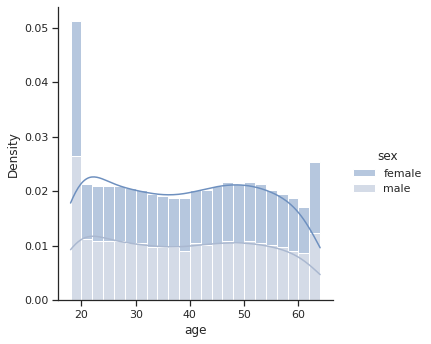

In [ ]:
sns.displot(medical_df, x="age", hue="sex", stat="density", kde=True,
            binwidth=2, multiple='stack');

Overall, the age of the dataset is uniform with evenly distribution of 22-38 customers each. However, the amount of 18 and 19 years old are twice as much other ages 

#### Features and target pairplot

##### Age Distribution vs. Charges

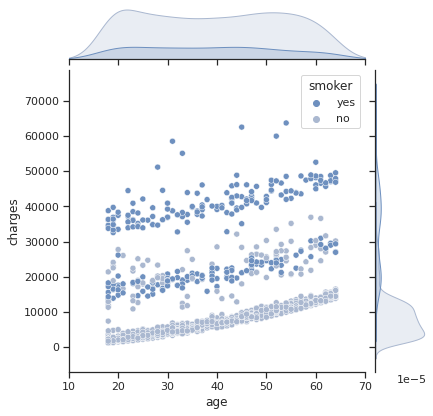

In [ ]:
sns.jointplot(data=medical_df, x='age', y='charges', hue='smoker', xlim=(10, 70));

The dataset split into 3 groups strongly correlate with smoking status. Lower charges group are non-smoker from every ages. The second group consist of both smoker and non-smoker with charges range in the middle. There seem to be smoker without serious medical issues and non-smoker with medium medical charges. The last group are people with smoking status with charges main range from 40k-50.

##### BMI Distribution vs. Charges

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:2073: UserWarning:

The `size` parameter has been renamed to `height`; please update your code.



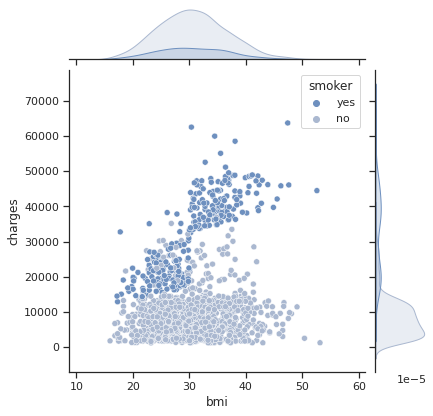

In [ ]:
sns.jointplot('bmi', 'charges', data=medical_df, hue='smoker', size=6);

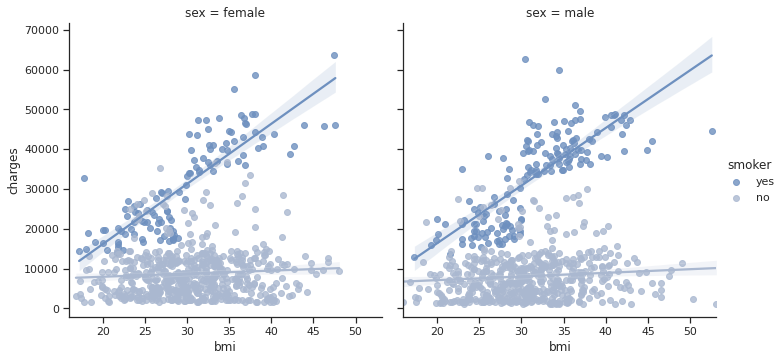

In [ ]:
sns.lmplot(data=medical_df, x='bmi', y='charges', col='sex', hue='smoker');

There seem to be no correlation between BMI and medical charges. However, there is a visual seperation between smoker and non-smoker. Overall, smokers have much higher charges which is increase as age increase. Whereras, non-smoker have a lower and stable cost in medical even when age increase.

##### Children Distribution vs Charges Boxplot

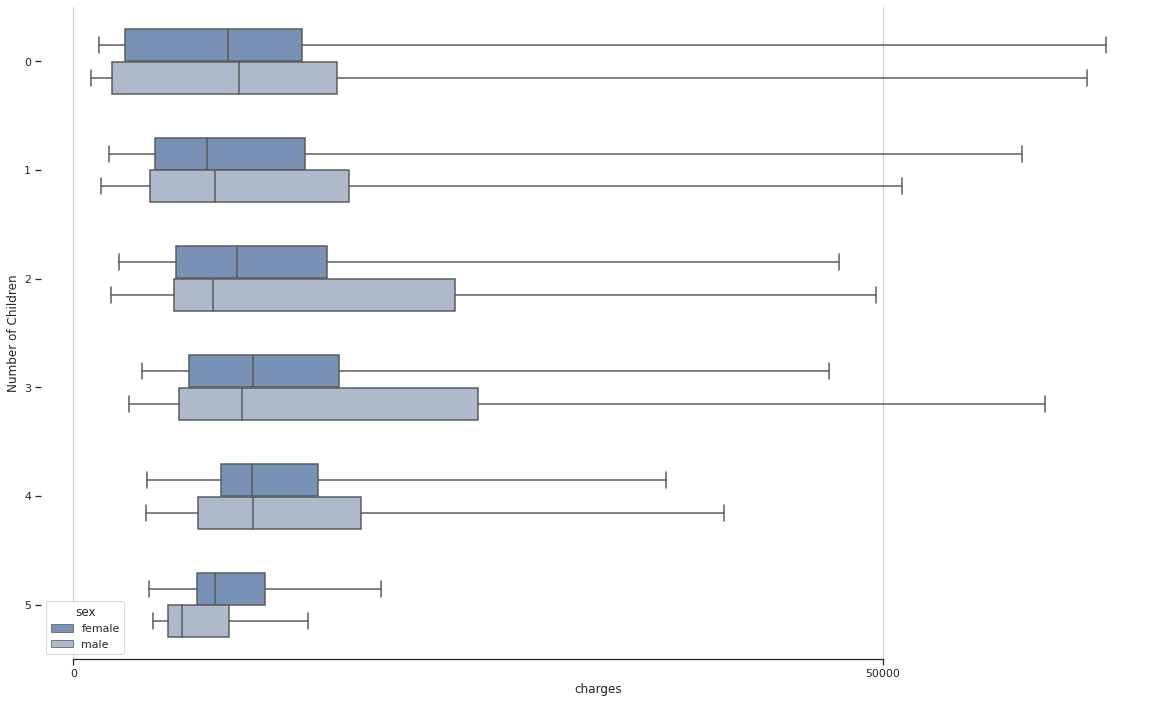

In [ ]:
f, ax = plt.subplots(1, 1)
fig = sns.boxplot(data=medical_df, x='charges', y='children', hue='sex', 
            whis=[0,100], orient='h', width=.6)


ax.xaxis.grid(True)
ax.set(ylabel="Number of Children")
sns.set(font_scale=12)
sns.despine(trim=True, left=True);

In [ ]:
sns.catplot(x="children", y="charges",
                hue="sex", col='smoker',
                data=medical_df, kind="box");

There seem to be no strong correlation between number of children to medical charges. Customers who have 2-3 childrens have slight higher average medical charges but not strong enough to make conclusion.

### Correlation 
There are columns with closer relationship with medical charges. We can use `.corr `method from Pandas to compute **correlation coefficient** in numeric values. Therefore, we must convert catergorical columns to numeric values.

In [ ]:
# correlation between charges and age
medical_df.charges.corr(medical_df.age)

Here's how correlation coefficients can be interpreted (source):

- **Strength**: The greater the absolute value of the correlation coefficient, the stronger the relationship.

    - The extreme values of -1 and 1 indicate a perfectly linear relationship where a change in one variable is accompanied by a perfectly consistent change in the other. For these relationships, all of the data points fall on a line. In practice, you won’t see either type of perfect relationship.

    - A coefficient of zero represents no linear relationship. As one variable increases, there is no tendency in the other variable to either increase or decrease.

    - When the value is in-between 0 and +1/-1, there is a relationship, but the points don’t all fall on a line. As r approaches -1 or 1, the strength of the relationship increases and the data points tend to fall closer to a line.

- **Direction:** The sign of the correlation coefficient represents the direction of the relationship.

  - Positive coefficients indicate that when the value of one variable increases, the value of the other variable also tends to increase. Positive relationships produce an upward slope on a scatterplot.

  - Negative coefficients represent cases when the value of one variable increases, the value of the other variable decrease. Negative relationships produce a downward slope.

Convert Smoker column to numeric values

In [ ]:
smoker_values = {'no': 0, 'yes': 1}
medical_df['smoker_numeric'] = medical_df['smoker'].map(smoker_values)
medical_df.charges.corr(medical_df.smoker_numeric)

We can compute the correlation coefficients between all pairs of numeric columns with `.corr`

In [ ]:
corr_table = medical_df.corr()

We can create correaltion matrix with seaborn `heatmap`

In [ ]:
sns.heatmap(corr_table, cmap='Blues_r', annot=True)
plt.title('Correlation Matrix');

**Correlation vs causation fallacy:** Note that a high correlation cannot be used to interpret a cause-effect relationship between features. Two features 
X
 and 
Y
 can be correlated if 
X
 causes 
Y
 or if 
Y
 causes 
X
, or if both are caused independently by some other factor 
Z
, and the correlation will no longer hold true if one of the cause-effect relationships is broken. It's also possible that 
X
 are 
Y
 simply appear to be correlated because the sample is too small.

### Preprocessing Data
- Feature Scalling
- Encoding Catergorical values
- Splitting Data: Creating Validation Set

Apply Feature Scalling with `StandardScaler` from `scikit-learn`



Create a deep copy of `Medical_df` to store training data, which is encoded values

In [ ]:
training_df = medical_df.copy(deep=True)

Features Scalling

In [ ]:
numeric_cols = ['age', 'bmi', 'children'] 
scaler = preprocessing.StandardScaler()

training_df[['ages', 'bmi', 'children']] = scaler.fit_transform(medical_df[numeric_cols])
scaler.var_, scaler.mean_

Catergorical Encoding

In [ ]:
label_encoder = preprocessing.OrdinalEncoder()
training_df['sex'] = label_encoder.fit_transform(medical_df[['sex']])
training_df['smoker'] = label_encoder.fit_transform(medical_df[['smoker']])

In [ ]:
encoder = preprocessing.OneHotEncoder()
encoded_regions = encoder.fit_transform(medical_df[['region']]).toarray()
training_df[['northeast', 'northwest', 'southeast', 'southwest']] = encoded_regions

training_df.drop(['region'], axis=1, inplace=True)

Define train and predict targets

In [ ]:
features = training_df.drop(['charges'], axis=1).values
targets = training_df.charges.values

Creating Validation Set

Using `train_test_split` from scikit-learn to split features and targets values into training dataset and test set, which will be used to evaluate model

In [ ]:
features_train, features_test, targets_train, targets_test = train_test_split(features, targets, test_size=0.2)

### Linear Regression with a Single Feature
We'll use smoker and age of customers to predict charges as we know "smoker" and "age" have strong relationship with "charges"

Create a dataframe with chosen values

In [ ]:
non_smoker_df = medical_df[medical_df.smoker == 'no']

In [ ]:
fig = px.scatter(non_smoker_df, x='age', y='charges', size='charges', 
                 title='Non-smoker Medical Charges', size_max=15,
                 hover_data=['children', 'sex'], color='children')
fig.show();

In [ ]:
feature = non_smoker_df[['age']]
targets = np.array(non_smoker_df[['charges']])
targets = targets.reshape(-1, 1)
features = features.reshape(-1, 1)
features.shape, targets.shape

((3192, 1), (1064, 1))

In [ ]:
model = LinearRegression()

In [ ]:
model.fit(feature, targets)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
model.predict(feature)

array([[2719.0598744 ],
       [5391.54900271],
       [6727.79356686],
       ...,
       [2719.0598744 ],
       [2719.0598744 ],
       [3520.80661289]])

In [ ]:
model.score(feature, targets)

0.39431716324259036

### Linear Regression with a Multiple Features

Create a dataframe with chosen values and plot on graph

In [ ]:
non_smoker_df = medical_df[medical_df.smoker == 'no']

In [ ]:
fig = px.scatter_3d(non_smoker_df, 'bmi', 'age', 'charges', color='children', title='Non-Smoker Medical Charges')
fig.update_traces(marker_size=4, marker_opacity=0.5)
fig.show()

In [ ]:
features = np.array(non_smoker_df[['age', 'bmi', 'children']])
targets = np.array(non_smoker_df['charges'])

In [ ]:
targets = targets.reshape(-1, 1)

In [ ]:
model = LinearRegression()
model.fit(features, targets)
model.predict(features)

array([[2724.94209163],
       [6535.13457204],
       [6065.27173951],
       ...,
       [2134.51524931],
       [2160.54349555],
       [2898.08585583]])

In [ ]:
model.score(features, targets)

0.408274740172451

### Linear Regression Model with Scikit-Learn
Create a linear regression model using scikit-learn libraries.

we can use `help` on model method to access to its parameter information



In [ ]:
model = LinearRegression()

Train the model with train dataset

In [ ]:
model.fit(features_train, targets_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Model's coefficient/weights and intercept/bias

In [ ]:
model.coef_, model.intercept_

(array([ 2.50289750e+02, -1.60430451e+02,  2.23230803e+03,  6.84408736e+02,
         2.38589878e+04,  1.78209281e+01,  9.16466230e+02,  1.84090115e+02,
        -4.99247044e+02, -6.01309301e+02]), -1152.6895288644955)

In [ ]:
weight_df = pd.DataFrame({'Features': np.append(training_df.drop('charges', axis=1).columns, 'Bias'),
                          'Weights': np.append(model.coef_, model.intercept_)})
weight_df.sort_values(by='Weights', ascending=False).head()

,Features,Weights
4,smoker,23858.987772
2,bmi,2232.308027
6,northeast,916.466230
3,children,684.408736
0,age,250.289750


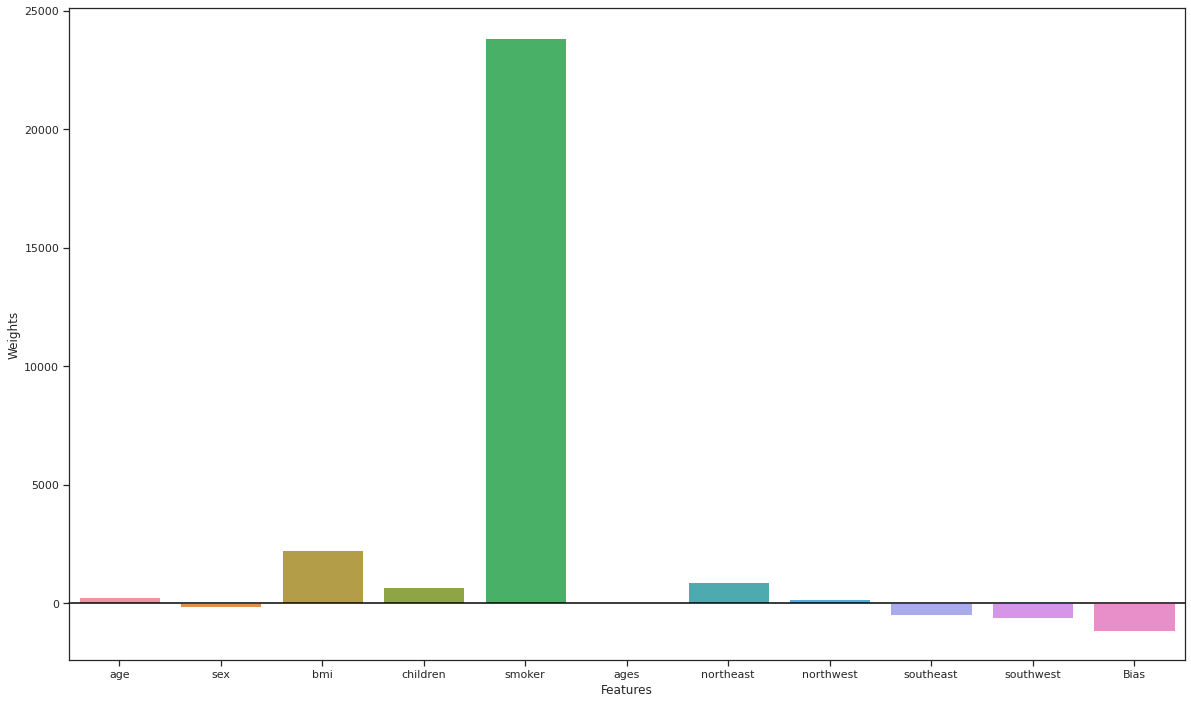

In [ ]:
f, ax = plt.subplots(1, 1)
sns.barplot(x='Features', y='Weights', data=weight_df)
ax.axhline(0, color='k', clip_on=False);



As indicated, smoking status, age and BMI are important features

##### Learning Curve

In [ ]:
from sklearn.model_selection import learning_curve

In [ ]:
datasize, train_scores, test_scores = learning_curve(model, features_train, targets_train, 
                                                    scoring='r2', return_times=False)

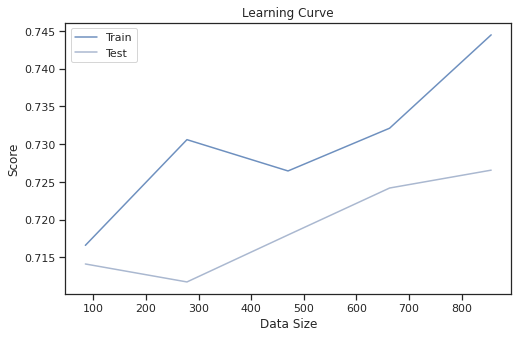

In [ ]:
plt.figure(figsize=(8,5))

plt.plot(datasize, np.mean(train_scores, axis=1))
plt.plot(datasize, np.mean(test_scores, axis=1))
plt.title('Learning Curve')
plt.ylabel('Score')
plt.xlabel('Data Size')
plt.legend(['Train', 'Test']);

### Model Evaluation

Loss Function


> **Root mean squared error (RMSE)** is used to caluclate the loss of linear prediction



In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error as MSE

In [ ]:
train_pred = model.predict(features_train)
test_pred = model.predict(features_test)

In [ ]:
cross_val_score(model, features_train, targets_train, cv=3)

array([0.69362256, 0.72372306, 0.78141877])

In [ ]:
train_loss = np.sqrt(MSE(targets_train, train_pred))
test_loss = np.sqrt(MSE(targets_test, test_pred))
print(f'Train Loss: {train_loss}, Test Loss: {test_loss}')

Train Loss: 6217.180820166021, Test Loss: 5333.132431249992
